In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as datetime
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
from sklearn import metrics
import gc
gc.enable()
# Input data files are available in the "../input/" directory.
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
import os

In [ ]:
json_data=["device","geoNetwork","totals","trafficSource"]

gc.enable()
features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device_browser',\
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',\
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',\
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',\
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',\
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',\
       'trafficSource_adContent', 'trafficSource_campaign',\
       'trafficSource_isTrueDirect', 'trafficSource_keyword',\
       'trafficSource_medium', 'trafficSource_referralPath',\
       'trafficSource_source']
def load_df(csv_path='C:/Users/saidh/Desktop/projects/Google Analytics/train_v2.csv'):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                    chunksize = 100000)
    for df in dfs:
        df.reset_index(drop = True,inplace = True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis = 0).reset_index(drop = True)
        print(ans.shape)
    return ans

train = load_df()
train.shape

C:\Users\saidh\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [3]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,trafficSource_adContent,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [4]:
test=load_df(csv_path='C:/Users/saidh/Downloads/test_v2.csv')

C:\Users\saidh\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Loaded test_v2.csv. Shape: (100000, 59)
(100000, 29)
Loaded test_v2.csv. Shape: (100000, 59)
(200000, 29)
Loaded test_v2.csv. Shape: (100000, 59)
(300000, 29)
Loaded test_v2.csv. Shape: (100000, 59)
(400000, 29)
Loaded test_v2.csv. Shape: (1589, 59)
(401589, 29)


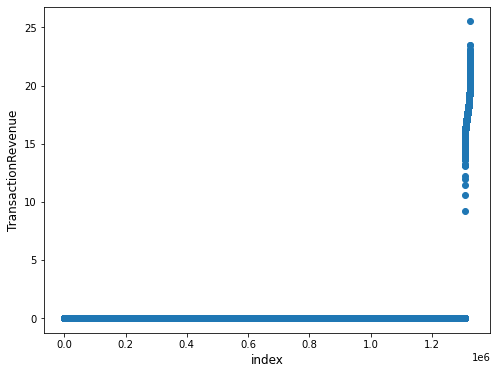

In [5]:
train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')
total_revenue=train.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()
plt.figure(figsize=(8,6))
plt.scatter(range(total_revenue.shape[0]), np.sort(np.log1p(total_revenue["totals_transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [6]:
def chats(data):
    trace = go.Bar(y=data.index[::-1],
                   x=data.values[::-1],
                   showlegend=False,
                   orientation = 'h',
    )
    return trace
data=train.groupby("device_browser")["totals_transactionRevenue"].agg(["size","count","mean"])
data.columns=["count", "count of non-zero revenue", "mean"]
data=data.sort_values(by="count",ascending=False)
trace1=chats(data["count"].head(10))
trace2=chats(data["count of non-zero revenue"].head(10))
trace3=chats(data["mean"].head(10))


data=train.groupby("device_deviceCategory")["totals_transactionRevenue"].agg(["size","count","mean"])
data.columns=["count", "count of non-zero revenue", "mean"]
data=data.sort_values(by="count",ascending=False)
trace4=chats(data["count"].head(10))
trace5=chats(data["count of non-zero revenue"].head(10))
trace6=chats(data["mean"].head(10))

data=train.groupby("device_operatingSystem")["totals_transactionRevenue"].agg(["size","count","mean"])
data.columns=["count", "count of non-zero revenue", "mean"]
data=data.sort_values(by="count",ascending=False)
trace7=chats(data["count"].head(10))
trace8=chats(data["count of non-zero revenue"].head(10))
trace9=chats(data["mean"].head(10))


# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

C:\Users\saidh\Anaconda3\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [7]:
train.head(10)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,trafficSource_adContent,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
5,Referral,20171016,0166277907528479249,1508196701,1,1508196701,Chrome,desktop,False,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,unknown.unknown,California,Northern America,NaN,2,1,2,NaN,NaN,(not set),NaN,NaN,(none),/offer/2145,(direct)
6,Referral,20171016,8349655975937271469,1508152478,1,1508152478,Chrome,desktop,False,Macintosh,London,Europe,United Kingdom,London,(not set),England,Northern Europe,NaN,2,1,2,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/nest-vision/dropcam-field-tester...,sites.google.com
7,Organic Search,20171016,1332629902468998662,1508206208,1,1508206208,Chrome,desktop,False,Windows,not available in demo dataset,Europe,Denmark,not available in demo dataset,fullrate.ninja,not available in demo dataset,Northern Europe,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
8,Organic Search,20171016,632878546807742341,1508207516,1,1508207516,Chrome,desktop,False,Macintosh,Mexico City,Americas,Mexico,(not set),uninet-ide.com.mx,Mexico City,Central America,NaN,2,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
9,Organic Search,20171016,1259490915281096752,1508165159,2,1508165159,Safari,mobile,True,iOS,not available in demo dataset,Europe,Netherlands,not available in demo dataset,(not set),not available in demo dataset,Western Europe,NaN,2,NaN,2,NaN,NaN,(not set),True,(not provided),organic,NaN,google


In [8]:
network_Country=train.groupby("geoNetwork_country")["totals_transactionRevenue"].agg(["size","count","mean"])
network_Country.columns=["Country_count", "Country_count of non-zero revenue", "mean"]
network_Country=network_Country.sort_values(by="Country_count",ascending=False)
trace1=chats(network_Country["Country_count"].head(10))
trace2=chats(network_Country["Country_count of non-zero revenue"].head(10))
trace3=chats(network_Country["mean"].head(10))



#continent
network_continent=train.groupby("geoNetwork_continent")["totals_transactionRevenue"].agg(["size","count","mean"])
network_continent.columns=["Continent_count", "Continent_count of non-zero revenue", "mean"]
network_continent=network_continent.sort_values(by="Continent_count",ascending=False)
trace4=chats(network_continent["Continent_count"].head(10))
trace5=chats(network_continent["Continent_count of non-zero revenue"].head(10))
trace6=chats(network_continent["mean"].head(10))


network_continent=train.groupby("geoNetwork_networkDomain")["totals_transactionRevenue"].agg(["size","count","mean"])
network_continent.columns=["networkDomain_count", "networkDomain_count of non-zero revenue", "mean"]
network_continent=network_continent.sort_values(by="networkDomain_count",ascending=False)
trace7=chats(network_continent["networkDomain_count"].head(10))
trace8=chats(network_continent["networkDomain_count of non-zero revenue"].head(10))
trace9=chats(network_continent["mean"].head(10))

fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='geoNetwork-plots')

C:\Users\saidh\Anaconda3\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [9]:
traffic_source=train.groupby("trafficSource_source")["totals_transactionRevenue"].agg(["size","count","mean"])
traffic_source.columns=["traffic_source_count", "traffic_source_count of non-zero revenue", "mean"]
traffic_source=traffic_source.sort_values(by="traffic_source_count",ascending=False)
trace1=chats(traffic_source["traffic_source_count"].head(10))
trace2=chats(traffic_source["traffic_source_count of non-zero revenue"].head(10))
trace3=chats(traffic_source["mean"].head(10))



#medium
traffic_medium=train.groupby("trafficSource_medium")["totals_transactionRevenue"].agg(["size","count","mean"])
traffic_medium.columns=["traffic_medium_count", "traffic_medium_count of non-zero revenue", "mean"]
traffic_medium=traffic_medium.sort_values(by="traffic_medium_count",ascending=False)
trace4=chats(traffic_medium["traffic_medium_count"].head(10))
trace5=chats(traffic_medium["traffic_medium_count of non-zero revenue"].head(10))
trace6=chats(traffic_medium["mean"].head(10))




fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='geoNetwork-plots')

In [10]:
import datetime
def scatter_plot(data):
    trace = go.Scatter(
        x=data.index[::-1],
        y=data.values[::-1],
        showlegend=False,
        #mode = 'lines+markers',
    )
    return trace
train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
date_trans=train.groupby("date")["totals_transactionRevenue"].agg(["size","count"])
date_trans.columns = ["count", "count of non-zero revenue"]
date_trans = date_trans.sort_index()

trace1=scatter_plot(date_trans["count"])
trace2=scatter_plot(date_trans["count of non-zero revenue"])
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="date-plots for count & Revenue")
py.iplot(fig, filename='date-plots')

In [11]:
print("Variables in train and not in test` : ", set(train.columns).difference(set(test.columns)))

Variables in train and not in test` :  set()


In [12]:
train.shape,test.shape

((1708337, 29), (401589, 29))

In [13]:
train["totals_transactionRevenue"].fillna(0, inplace=True)
train_y = train["totals_transactionRevenue"].values

In [14]:
num_cols = ["totals_hits", "totals_pageviews", "visitNumber", "visitStartTime", 'totals_bounces',  'totals_newVisits']    
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'nb_sessions', 'max_visits','visit_time','totals_visits'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

categorical_features

['channelGrouping',
 'device_browser',
 'device_deviceCategory',
 'device_operatingSystem',
 'geoNetwork_city',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'trafficSource_adContent',
 'trafficSource_campaign',
 'trafficSource_isTrueDirect',
 'trafficSource_keyword',
 'trafficSource_medium',
 'trafficSource_referralPath',
 'trafficSource_source']

In [15]:
train_val=np.log1p(train_y)
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,trafficSource_adContent,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,0,2017-10-16,3162355547410993243,1508198450,1.0,1.508198e+09,0,0,False,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,0.0,-1,0,-1,0,0,-1,0
1,1,2017-10-16,8934116514970143966,1508176307,6.0,1.508176e+09,1,0,False,1,1,1,1,1,0,1,1,NaN,2.0,NaN,2.0,0.0,-1,0,-1,-1,1,0,1
2,2,2017-10-16,7992466427990357681,1508201613,1.0,1.508202e+09,1,1,True,2,0,1,1,0,1,0,1,NaN,2.0,1.0,2.0,0.0,-1,0,0,-1,2,-1,2
3,0,2017-10-16,9075655783635761930,1508169851,1.0,1.508170e+09,1,0,False,0,0,2,2,0,2,0,2,NaN,2.0,1.0,2.0,0.0,-1,0,-1,1,0,-1,0
4,0,2017-10-16,6960673291025684308,1508190552,1.0,1.508191e+09,1,0,False,0,0,1,3,0,3,0,3,NaN,2.0,1.0,2.0,0.0,-1,0,-1,1,0,-1,0


In [16]:
train["totals_transactionRevenue"].fillna(0, inplace=True)
train_y = train["totals_transactionRevenue"]
train_val=np.log1p(train_y)

In [17]:
train_x,test_x,val_x,val_y=train_test_split(train,train_val,test_size=0.2, random_state=42)
trn_x=train_x[categorical_features+num_cols]
tst_x=test_x[categorical_features+num_cols]
test_X=test[categorical_features+num_cols]
test_X.head()

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,trafficSource_adContent,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,totals_hits,totals_pageviews,visitNumber,visitStartTime,totals_bounces,totals_newVisits
0,0,1,1,2,5,2,9,3,2,26,5,-1,0,0,1,0,-1,0,4.0,3.0,2.0,1.526099e+09,NaN,NaN
1,2,1,0,3,2,1,1,1,0,1,1,-1,0,0,-1,2,-1,2,4.0,3.0,166.0,1.526064e+09,NaN,NaN
2,0,1,0,1,0,1,1,0,-1,0,1,-1,0,0,1,0,-1,0,4.0,3.0,2.0,1.526067e+09,NaN,NaN
3,2,1,1,4,66,1,1,20,0,32,1,-1,0,0,-1,2,-1,2,5.0,4.0,4.0,1.526108e+09,NaN,NaN
4,0,4,2,0,49,1,1,5,97,1,1,-1,0,-1,1,0,-1,0,5.0,4.0,1.0,1.526060e+09,NaN,1.0


In [18]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(trn_x, val_x,tst_x, val_y, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.52206
[200]	valid_0's rmse: 1.51446
[300]	valid_0's rmse: 1.51271
[400]	valid_0's rmse: 1.51198
[500]	valid_0's rmse: 1.51114
[600]	valid_0's rmse: 1.51086
Early stopping, best iteration is:
[546]	valid_0's rmse: 1.51029


In [19]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":test_x["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = test_x["totals_transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

C:\Users\saidh\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



1.5236787830542722


In [20]:
submission = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
pred_test[pred_test<0] = 0
submission["PredictedLogRevenue"] = np.expm1(pred_test)
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission.to_csv("predicted_values.csv", index=False)

In [21]:
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.019480
1,0000039738481224681,0.005557
2,0000073585230191399,0.000540
3,0000087588448856385,0.000000
4,0000149787903119437,0.007357
5,0000196310838896290,1.588587
6,00001995526696366,0.000000
7,0000255704530917106,0.298740
8,0000268499301061358,0.000867
9,0000276747989270229,0.112829


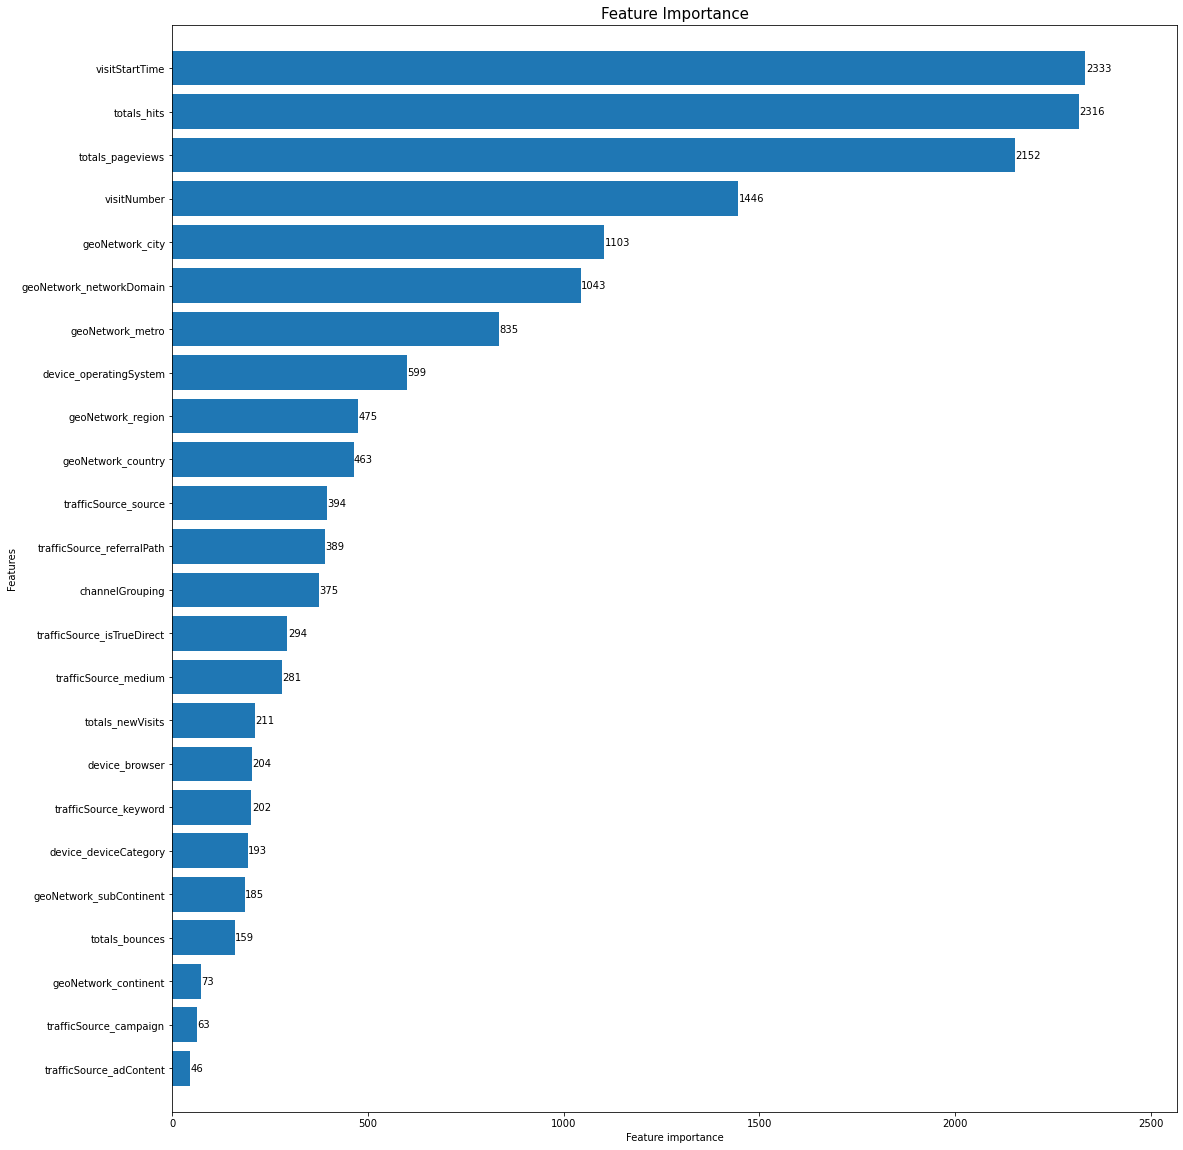

In [22]:
fig, ax = plt.subplots(figsize=(18,20))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=15)
plt.show()